In [165]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h3

import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

In [166]:
h3_l7_df = pd.read_csv('h3_l7_df_new.csv')
h3_l7_df.drop(columns=['commercial;yes'], inplace=True)

train_index=[]
test_index=[]
for i in range(0,h3_l7_df.shape[0]):
    geo_location = h3.h3_to_geo(h3_l7_df.iloc[i]['id'])

    if (geo_location[1]) > (-76.05): #把經度大於-76.05的 當train (東邊是train)
        train_index.append(i)
    else:
        test_index.append(i)

# 分割訓練集和測試集
train_h3_l7_df = h3_l7_df.iloc[train_index]
test_h3_l7_df = h3_l7_df.iloc[test_index]

# 將 h3_l7_df 資料框中的 'id' 列移除，僅保留數據進行正規化
h3_spatial_data = h3_l7_df.drop('id', axis=1)


# # # 對數據進行正規化：將每個數據列的最小值調整為 0，最大值調整為 1
normalized_spatial_data = (h3_spatial_data - h3_spatial_data.min()) / (h3_spatial_data.max() - h3_spatial_data.min())

#設定OHCA正規化反函數 方便把預測結果返回原本scale
ohca_reguli_inverse = (h3_l7_df.ohca.max()-h3_l7_df.ohca.min()) + h3_l7_df.ohca.min()

# 將 DataFrame 轉換為 numpy array，並設定數據類型為 np.float64
spatial_data = np.array(normalized_spatial_data).astype(np.float64)


train_spatial_data = spatial_data[train_index]
test_spatial_data = spatial_data[test_index]

# 分离特征和标签
X = spatial_data[:, :-1]  # 特征
Y = spatial_data[:, -1]   # 标签（OHCA）

X_train_reguli = train_spatial_data[:, :-1] 
y_train_reguli = train_spatial_data[:, -1] 
X_test_reguli = test_spatial_data[:, :-1] 
y_test_reguli = test_spatial_data[:, -1] 


# XGboost 指定參數


In [167]:
# 定義XGBoost模型並指定參數
best_xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=277,
    early_stopping_rounds=10,
    # 以下是您指定的參數值，請根據需要修改這些值
    max_depth=3,               # 樹的最大深度
    learning_rate=0.2,         # 學習率
    n_estimators=100,          # 樹的數量
    subsample=0.7,            # 每棵樹隨機採樣的比例 0.7
    colsample_bytree=0.7,      # 每棵樹使用的特徵比例 0.7
    gamma=0,                # 控制節點分裂的最小增益
    reg_alpha=0.1,            # L1正則化強度 0
    reg_lambda=1,           # L2正則化強度
    min_child_weight=3        # 每個葉子節點的最小樣本權重
)

# 訓練模型
best_xgb_model.fit(
    X_train_reguli, y_train_reguli,
    eval_set=[(X_test_reguli, y_test_reguli)],  # 提供測試集進行早停監控
    verbose=True
)

# 預測訓練集結果
y_head_train = best_xgb_model.predict(X_train_reguli) * ohca_reguli_inverse
y_train = y_train_reguli * ohca_reguli_inverse
# 預測測試集結果
y_head_test = best_xgb_model.predict(X_test_reguli) * ohca_reguli_inverse
y_test = y_test_reguli * ohca_reguli_inverse


#評估成效
train_mae = np.abs(y_head_train-y_train)
train_ans_mae = train_mae.sum()/train_mae.shape[0]
print('MAE of train set= ',train_ans_mae)
# 計算殘差變異
train_ss_residual = np.sum((y_train - y_head_train) ** 2)
# 計算總變異量
train_ss_total = np.sum((y_train - np.mean(y_train)) ** 2)
# 計算 R²
train_r_squared = 1 - (train_ss_residual / train_ss_total)
print("R² of train set= ", train_r_squared)

test_mae = np.abs(y_head_test-y_test)
test_ans_mae = test_mae.sum()/test_mae.shape[0]
print('MAE of test set= ',test_ans_mae)
# 計算殘差變異
test_ss_residual = np.sum((y_test - y_head_test) ** 2)
# 計算總變異量
test_ss_total = np.sum((y_test - np.mean(y_test)) ** 2)
# 計算 R²
test_r_squared = 1 - (test_ss_residual / test_ss_total)
print("R² of test set= ", test_r_squared)

[0]	validation_0-rmse:0.24953
[1]	validation_0-rmse:0.22717
[2]	validation_0-rmse:0.21675
[3]	validation_0-rmse:0.19437
[4]	validation_0-rmse:0.17980
[5]	validation_0-rmse:0.17177
[6]	validation_0-rmse:0.16906
[7]	validation_0-rmse:0.16359
[8]	validation_0-rmse:0.15430
[9]	validation_0-rmse:0.14877
[10]	validation_0-rmse:0.14466
[11]	validation_0-rmse:0.14188
[12]	validation_0-rmse:0.14336
[13]	validation_0-rmse:0.14145
[14]	validation_0-rmse:0.13830
[15]	validation_0-rmse:0.13515
[16]	validation_0-rmse:0.13363
[17]	validation_0-rmse:0.13014
[18]	validation_0-rmse:0.12816
[19]	validation_0-rmse:0.12567
[20]	validation_0-rmse:0.12576
[21]	validation_0-rmse:0.12480
[22]	validation_0-rmse:0.12508
[23]	validation_0-rmse:0.12501
[24]	validation_0-rmse:0.12522
[25]	validation_0-rmse:0.12447
[26]	validation_0-rmse:0.12380
[27]	validation_0-rmse:0.12462
[28]	validation_0-rmse:0.12306
[29]	validation_0-rmse:0.12252
[30]	validation_0-rmse:0.12137
[31]	validation_0-rmse:0.12029
[32]	validation_0-

# XGboost LIME

In [168]:
def correct_contributions(exp):
    lime_contributions = exp.as_list()
    original_contributions = []
    for feature, contribution in lime_contributions:
        original_contribution = contribution*ohca_reguli_inverse
        original_contributions.append((feature, original_contribution))
        
    return original_contributions

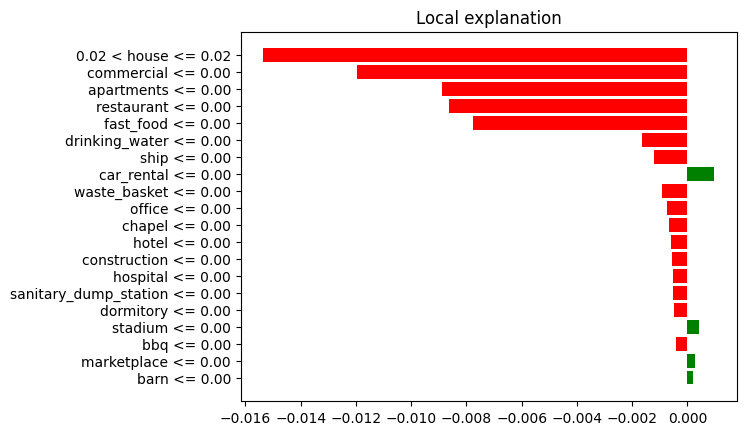

In [169]:
from lime import lime_tabular
from lime.lime_tabular import LimeTabularExplainer
import re

test_features_df = h3_spatial_data.iloc[:, :-1]
feature_names = test_features_df.columns

explainer = LimeTabularExplainer(
    training_data=np.array(X_train_reguli),
    feature_names=feature_names,
    mode='regression',
    kernel_width=0.75,         # 调整邻近样本的相似性范围
    discretize_continuous=True, # 启用连续特征的离散化
    discretizer='decile',     # 使用四分位数离散化
    random_state=42,            # 设置随机种子
  # 使用Lasso路径进行特征选择
)

# 選擇一個測試樣本進行解釋
idx = 36  # 可以修改 idx 來選擇不同樣本
exp = explainer.explain_instance(X_test_reguli[idx], best_xgb_model.predict, num_features=20)

# 繪製 LIME 解釋圖
exp.show_in_notebook(show_table=True, show_all=True)
exp.as_pyplot_figure()
plt.show()

In [170]:
# 提取貢獻值
exp = explainer.explain_instance(X_test_reguli[idx], best_xgb_model.predict, num_features=20)
contributions = exp.as_list()
contributions_set = (contributions,0)
def convert_to_dic(contributions_set):
    contribution_dict = {}
    contribution = contributions_set[0]
    Index = contributions_set[-1]
    print(Index)
    for i in range(0, len(contribution)-1):
        raw_feature = contribution[i][0]
        feature_name = re.sub(r'[^a-zA-Z_;]', '', raw_feature)
        if feature_name in feature_names:
            feature_val = test_h3_l7_df[feature_name].iloc[Index]
        else:
            feature_val = "?"
        feature_name = feature_name + ' = ' + str(feature_val)
        contribution_dict[feature_name] = contribution[i][1]

    return contribution_dict


convert_to_dic(contributions_set)

0


{'commercial = 0': -0.012913571313726006,
 'house = 2': -0.01248725593650041,
 'restaurant = 0': -0.010024471767106056,
 'apartments = 0': -0.009420703228418698,
 'fast_food = 0': -0.0050598460054557225,
 'fuel = 0': -0.004907283865343946,
 'fountain = 0': -0.00267327062016188,
 'toilets = 0': -0.0026432375540948465,
 'post_office = 0': -0.0013148721538218397,
 'bicycle_repair_station = 0': -0.0012970081098329104,
 'library = 0': -0.001214217184566493,
 'construction = 0': -0.0006853607789597314,
 'chapel = 0': -0.0005435897103107508,
 'bbq = 0': -0.0005279182204412906,
 'office = 0': 0.000487868458797422,
 'prep_school = 0': 0.000325915840273489,
 'exhibition_centre = 0': 0.0002979669431558653,
 'bicycle_rental = 0': 0.00022768086317000814,
 'sanitary_dump_station = 0': 0.00012667113640619016}

In [171]:
import matplotlib.pyplot as plt

def Lime_chart(contribution_dict):
    # 將貢獻字典按值排序（從大到小）
    sorted_contrib = sorted(contribution_dict.items(), key=lambda x: abs(x[1]), reverse=True)

    # 拆分成兩個 list
    features = [item[0] for item in sorted_contrib]
    contributions = [item[1] for item in sorted_contrib]

    # 畫圖
    plt.figure(figsize=(8, len(features) * 0.4))  # 高度依特徵數自動調整
    plt.barh(features, contributions, color=['green' if c >= 0 else 'red' for c in contributions])

    plt.xlabel("Contribution to prediction")
    plt.title("Feature Contributions")
    plt.gca().invert_yaxis()  # 讓最大貢獻的在上方
    plt.tight_layout()
    plt.show()


# Lime_chart(contribution_dict)

# 實現 SP-LIME 的子模塊優化

In [172]:
from tqdm import tqdm  # 用於顯示進度條
# 為每個測試樣本生成解釋
explanations = []
for i in tqdm(range(len(X_test_reguli))):
    exp = explainer.explain_instance(X_test_reguli[i]*ohca_reguli_inverse, best_xgb_model.predict, num_features=20)
    explanations.append((exp,i))

100%|██████████| 94/94 [00:10<00:00,  9.20it/s]


In [173]:
def submodular_pick(explanations, num_explanations):
    """
    使用貪婪算法進行子模塊優化，選擇代表性的解釋。
    
    :param explanations: 所有生成的解釋
    :param num_explanations: 要選擇的解釋數量
    :return: 選擇的代表性解釋
    """
    selected_explanations = []
    remaining_explanations = explanations.copy()
    
    # 計算每個解釋的特徵覆蓋範圍
    def coverage(exp):
        return set([f[0] for f in exp.as_list()])
    
    # 貪婪選擇
    for _ in range(num_explanations):
        best_exp = None
        best_gain = -1
        
        for exp in remaining_explanations:
            current_coverage = set()
            for selected_exp in selected_explanations:
                current_coverage.update(coverage(selected_exp[0]))
            
            new_coverage = current_coverage.union(coverage(exp[0]))
            gain = len(new_coverage) - len(current_coverage)
            
            if gain > best_gain:
                best_gain = gain
                best_exp = exp
        
        if best_exp is not None:
            selected_explanations.append((best_exp))
            remaining_explanations.remove((best_exp))
    
    return selected_explanations

Explanation 1:
0


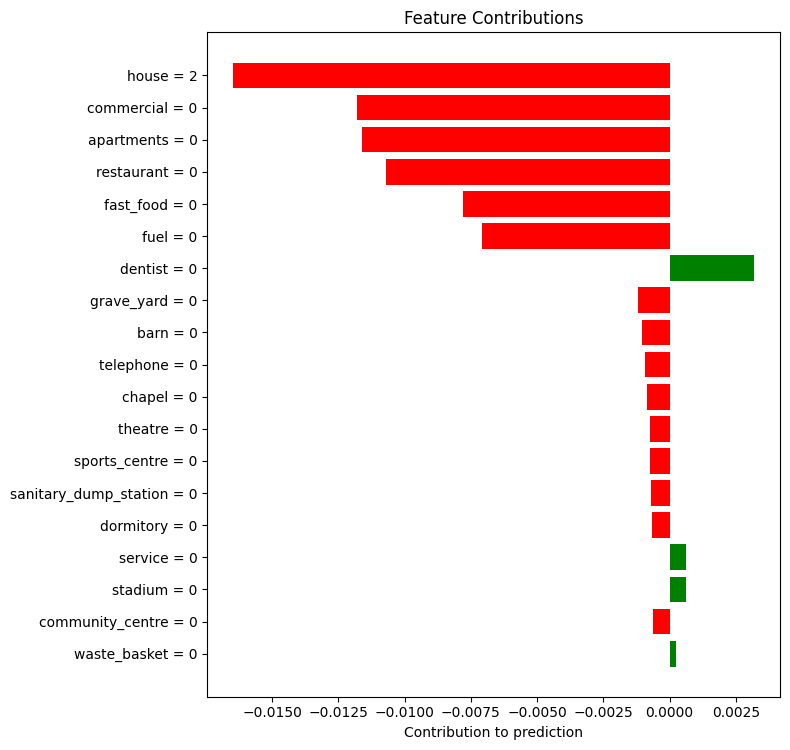

Explanation 2:
23


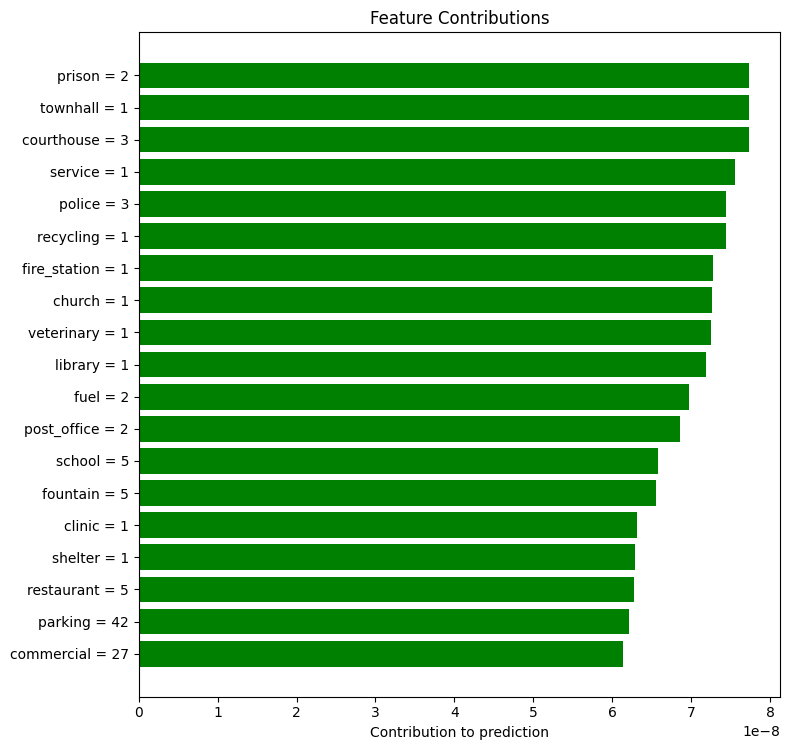

Explanation 3:
88


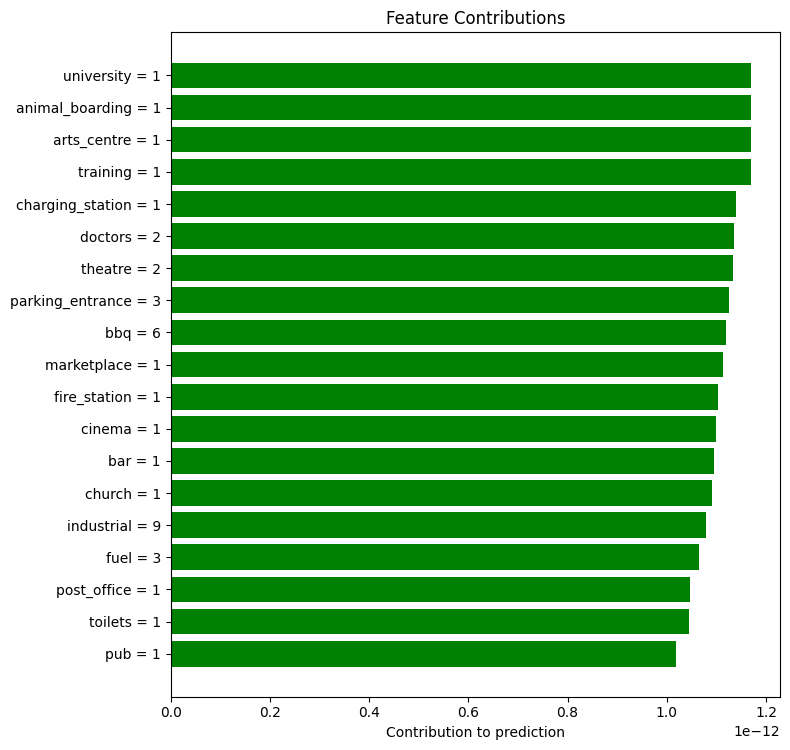

Explanation 4:
16


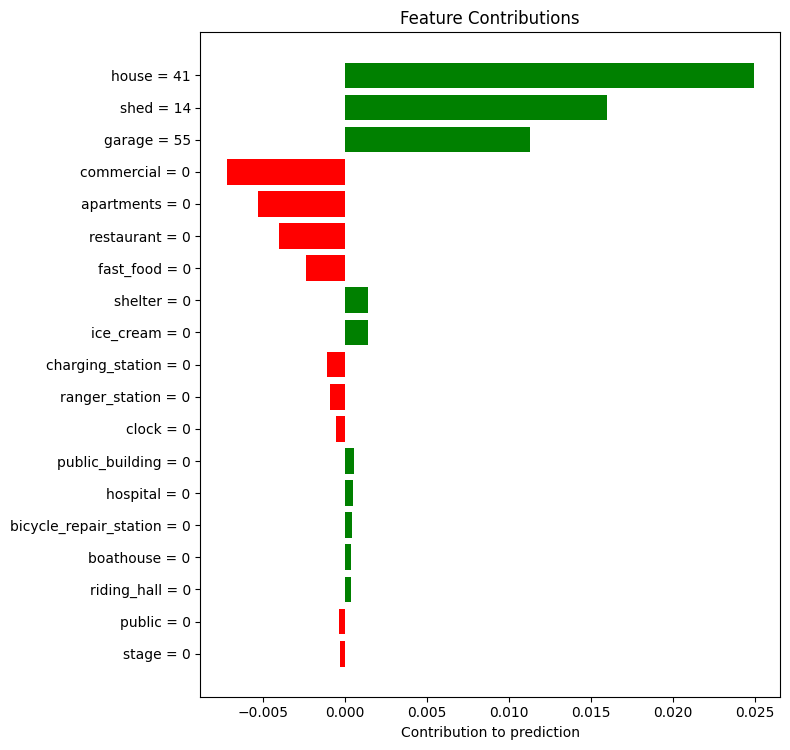

Explanation 5:
2


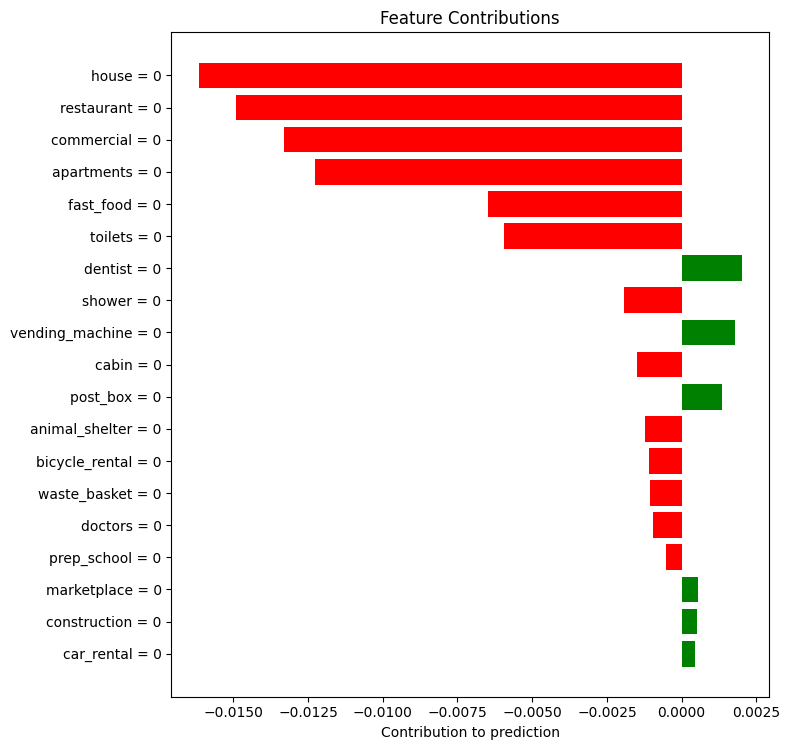

In [174]:
# 選擇 5 個代表性的解釋
num_explanations = 5
selected_explanations = submodular_pick(explanations, num_explanations)

# 打印選擇的解釋
for i, exp in enumerate(selected_explanations):
    print(f"Explanation {i+1}:")
    contribution = exp[0].as_list()
    contribution_set = (contribution,exp[1])
    contribution_dic = convert_to_dic(contribution_set)
    Lime_chart(contribution_dic)